In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset

from matplotlib import pyplot as plt

from PIL import Image
import os
from models import Classifier, ResNet_AutoEncoder

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))
])
train_dataset = torchvision.datasets.MNIST(root="C:\\Users\\hgugu\\Desktop\\Senior Project T\\Notebooks\\data", transform=transform)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_dataset = torchvision.datasets.MNIST(root="C:\\Users\\hgugu\\Desktop\\Senior Project T\\Notebooks\\data", transform=transform, train=False)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=True)

In [27]:
classifer = Classifier().to(device)
classifer.load_state_dict(torch.load("weights/classifier.pth",weights_only=True))
feature_net = classifer.features
feature_net.eval()
for param in feature_net.parameters():
    param.requires_grad = False

In [10]:
channels = [16,16,32,32,32]
num_of_blocks = 1
down_sample = [True]*((len(channels)-1))
latent_dim = 16
model_seman = ResNet_AutoEncoder(channels,num_of_blocks,down_sample,latent_dim).to(device)
model_seman.load_state_dict(torch.load("weights/semanticVAE_epoch50.pth"))
model_seman = model_seman .eval()
model_bvae = ResNet_AutoEncoder(channels,num_of_blocks,down_sample,latent_dim).to(device)
model_bvae.load_state_dict(torch.load("weights/b5-VAE_epoch50.pth"))
model_bvae = model_bvae.eval()
model_vae = ResNet_AutoEncoder(channels,num_of_blocks,down_sample,latent_dim).to(device)
model_vae.load_state_dict(torch.load("weights/VAE_epoch50.pth"))
model_vae = model_vae.eval()

In [22]:
def recon_mse_eval(model):
    model.eval() 
    running_val_loss_recon = 0.0
    with torch.no_grad(): 
        for val_images, _ in test_loader: 
            val_images = val_images.to(device)
            val_outputs,_, _, _ = model(val_images) 
            val_loss_recon = torch.nn.functional.mse_loss(val_images, val_outputs)
            running_val_loss_recon += val_loss_recon.item()

    avg_val_loss_recon = running_val_loss_recon / len(test_loader)
    return avg_val_loss_recon

In [23]:
print(f"Model 1: {recon_mse_eval(model_seman):.6f}")
print(f"Model 2: {recon_mse_eval(model_bvae):.6f}")
print(f"Model 3: {recon_mse_eval(model_vae):.6f}")

Model 1: 0.052554
Model 2: 0.086346
Model 3: 0.040324


In [24]:
def interpretability(model, bs=2**10, alpha=1, zdim=16, seed=17):
    torch.manual_seed(seed)
    with torch.no_grad():
        iteration = bs // 2**10
        total_mean = 0
        for i in range(iteration):
            z = torch.randn(2**10,zdim).to(device)
            d = torch.randn(1,zdim).repeat(2**10,1).to(device)
            z_prime = z + alpha*d 
            outputs1 = model.decode(z)
            outputs2 = model.decode(z_prime)
            difference = feature_net(outputs1).flatten(1) - feature_net(outputs2).flatten(1)
            meanvar = difference.var(dim=0).mean()
            total_mean += meanvar
        mean = total_mean/iteration
        return mean

In [28]:
print(f"Model 1: {interpretability(model_seman, bs=2**10):.6f}")
print(f"Model 2: {interpretability(model_bvae, bs=2**10):.6f}")
print(f"Model 3: {interpretability(model_vae, bs=2**10):.6f}")

Model 1: 0.558307
Model 2: 4.869759
Model 3: 3.664649


In [30]:
#Utils
def show(image):
    plt.imshow((image.cpu().detach().squeeze(0).permute(1,2,0)+1)/2, cmap="gray")
    plt.axis("off")
    plt.show()
def interpolate_show(image1,image2,model):
    with torch.no_grad():
        image1 = image1.to(device)
        image2 = image2.to(device)
        _, z1, _ , _ = model(image1)
        _, z2, _ , _ = model(image2)
    images = []
    for i in range(16):
        z = (z1*i+z2*(15-i))/15
        recon_img = model.decode(z)
        images.append(recon_img.squeeze(0))
    grid_img = torchvision.utils.make_grid(images, nrow=len(images),padding=0)
    grid_np = grid_img.permute(1, 2, 0).detach().cpu().numpy()
    plt.figure(figsize=(20, 5))
    show(grid_img)

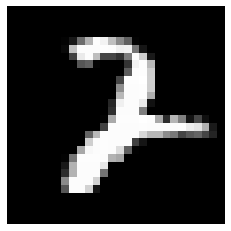

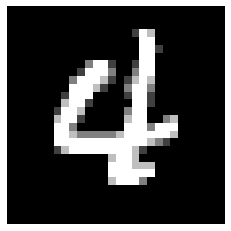

In [51]:
example_loader = DataLoader(test_dataset, batch_size=2,shuffle=True)
loader = iter(example_loader)
image1 = next(loader)[0][0].unsqueeze(0)
image2 = next(loader)[0][1].unsqueeze(0)
show(image1)
show(image2)

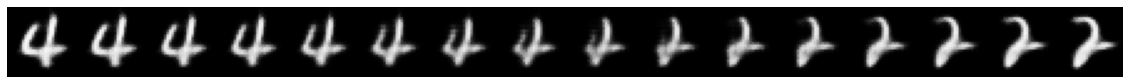

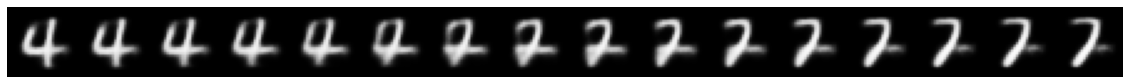

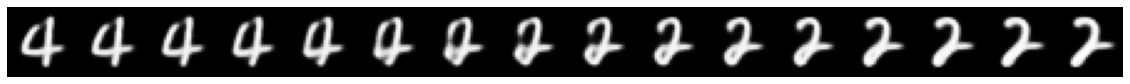

In [52]:
interpolate_show(image1,image2,model_seman)
interpolate_show(image1,image2,model_bvae)
interpolate_show(image1,image2,model_vae)

In [35]:
def z_norms(model, p=2):
    model.eval() # Set model to evaluation mode
    norms = []
    with torch.no_grad(): # Disable gradient calculations during validation
        for val_images, _ in test_loader: # Iterate through the test/validation loader
            val_images = val_images.to(device)
            _, z , _, _ = model(val_images)
            normst = z.norm(dim=1, p=p)
            norms.append(normst)
    return torch.concat(norms)

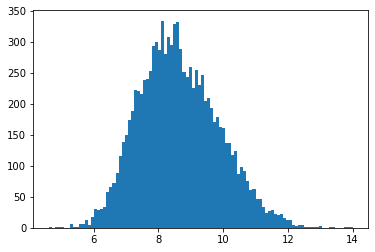

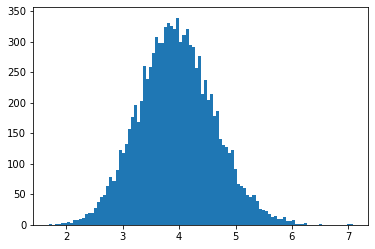

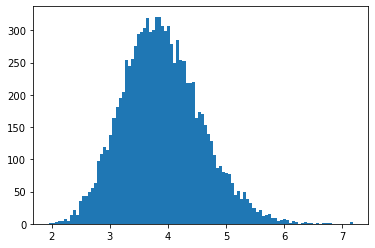

In [37]:
z_seman = z_norms(model_seman,p=2)
z_bvae = z_norms(model_bvae,p=2)
z_vae = z_norms(model_vae,p=2)
plt.hist(z_seman.cpu().numpy(),bins=100)
plt.show()
plt.hist(z_bvae.cpu().numpy(),bins=100)
plt.show()
plt.hist(z_vae.cpu().numpy(),bins=100)
plt.show()